Historic data processing

In [47]:
# Load packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os

Import raw data

In [48]:
# Load data from historic folder

def load_all_historic_files():
    base_path = Path.cwd().parent
    historic_folder = base_path / "data" / "raw" / "historic"
    
    dfs = []
    
    for file in historic_folder.glob("*.xlsx"):
        df = pd.read_excel(file)
        df["source_file"] = file.stem
        dfs.append(df)
    
    return pd.concat(dfs, ignore_index=True)

historic_data = load_all_historic_files()

Look at data

In [49]:
# Look at head, tail, and random samples from the data set
historic_data.head()
historic_data.tail()

# Look at shape, column names and index of the data set
historic_data.shape
historic_data.index
historic_data.columns

Index(['Ref', 'Project name', 'Country', 'Continent', 'Date online',
       'Decomission date', 'Status', 'Technology', 'Technology_details',
       'Technology_electricity', 'Technology_electricity_details', 'Product',
       'EndUse_Refining', 'EndUse_Ammonia', 'EndUse_Methanol',
       'EndUse_Iron&Steel', 'EndUse_Other Ind', 'EndUse_Mobility',
       'EndUse_Power', 'EndUse_Grid inj.', 'EndUse_CHP',
       'EndUse_Domestic heat', 'EndUse_Biofuels', 'EndUse_Synfuels',
       'EndUse_CH4 grid inj.', 'EndUse_CH4 mobility', 'Announced Size',
       'Capacity_MWel', 'Capacity_Nm³ H₂/h', 'Capacity_kt H2/y',
       'Capacity_t CO₂ captured/y',
       'IEA zero-carbon estimated normalized capacity [Nm³ H₂/hour]',
       'References', 'Location', 'Latitude', 'Longitude', 'source_file'],
      dtype='object')

Extract data for the needed years and technologies

In [50]:
# Include only the columns of interest in new dataframe
historic_data_columns = historic_data[["Date online", "Technology", "Capacity_MWel"]]

# Rename columns for easier handling
historic_data_columns.rename(columns={"Date online": "Year", "Capacity_MWel": "Capacity"}, inplace=True)

# Only include the years from 1990 to 2025
historic_data_columns = historic_data_columns[(historic_data_columns["Year"] >= 1990) & (historic_data_columns["Year"] <= 2025)]

# Check data set after selecting columns and renaming
historic_data_columns["Year"].unique()

C:\Users\idapo\AppData\Local\Temp\ipykernel_23844\1558426211.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historic_data_columns.rename(columns={"Date online": "Year", "Capacity_MWel": "Capacity"}, inplace=True)


array([2021., 2022., 2020., 2019., 2018., 2017., 2016., 2015., 2014.,
       2013., 2025., 2012., 2011., 2010., 2009., 2008., 2007., 2006.,
       2004., 2003., 2000., 2023., 2005., 2024., 1992.])

Sum capacities per technology

In [51]:
# Sum capacity by year and technology
historic_data_years = historic_data_columns.groupby(["Year", "Technology"]).sum().reset_index()

# Check data set after summing
historic_data_years.head()

,Year,Technology,Capacity
0,1992.0,ALK,0.70000
1,2000.0,ALK,0.05360
2,2000.0,PEM,0.00100
3,2003.0,ALK,1.45200
4,2003.0,PEM,0.00364


Visualize the data

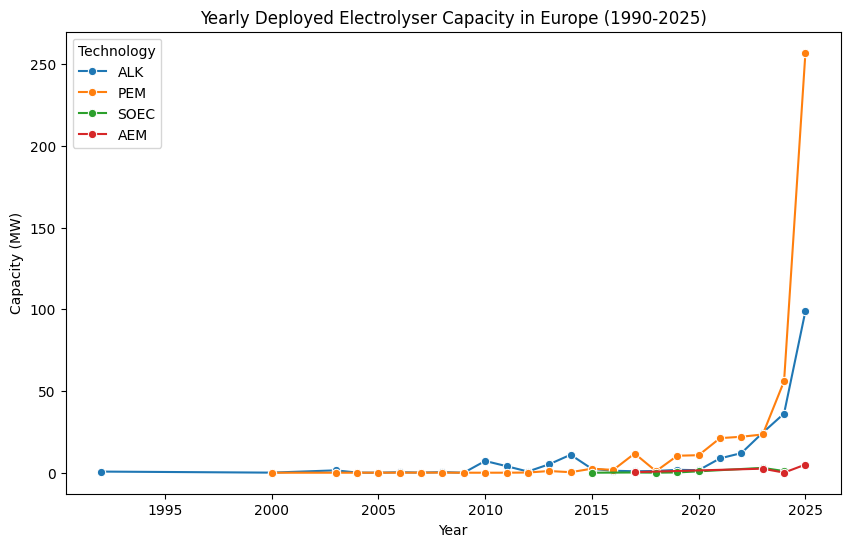

In [52]:
# Visualize the data with a plot

plt.figure(figsize=(10, 6))
sns.lineplot(data=historic_data_years, x="Year", y="Capacity", hue="Technology", marker="o")
plt.title("Yearly Deployed Electrolyser Capacity in Europe (1990-2025)")
plt.xlabel("Year")
plt.ylabel("Capacity (MW)")
plt.legend(title="Technology")
plt.show()

Dynamic Stock Model

In [53]:
# New dataframe with technology as columns and years as rows
historic_data_pivot = historic_data_columns.pivot_table(index="Year", columns="Technology", values="Capacity", aggfunc="sum").reset_index()

# Fill in missing years from 1990 to 2025
all_years = pd.DataFrame({"Year": range(1990, 2026)})
historic_data_pivot = pd.merge(all_years, historic_data_pivot, on="Year", how="left")

# Fill in missing values with 0
historic_data_pivot.fillna(0, inplace=True)

# Check data set after pivoting
historic_data_pivot.head()

,Year,AEM,ALK,PEM,SOEC
0,1990,0.0,0.0,0.0,0.0
1,1991,0.0,0.0,0.0,0.0
2,1992,0.0,0.7,0.0,0.0
3,1993,0.0,0.0,0.0,0.0
4,1994,0.0,0.0,0.0,0.0


Import dynamic stock model

In [54]:
# Import dynamic stock model
from dynamic_stock_model import DynamicStockModel

Use inflow driven model

In [57]:
# Create function to compute stock, outflow and stock change from inflow data using DynamicStockModel
def compute_stock_from_inflow(inflow, years, lifetime):

    inflow = np.array(inflow)
    t = np.array(years)

    # Make sure arrays have the correct shape
    for key, val in lifetime.items():
        if key != "Type" and np.array(val).shape[0] == 1:
            lifetime[key] = np.tile(val, len(t))

    # Initialize DSM
    dsm = DynamicStockModel(t=t, i=inflow, lt=lifetime, name="Stock Model")

    # Compute stock by cohort
    dsm.compute_s_c_inflow_driven()

    # Compute total stock
    s_total = dsm.compute_stock_total()

    # Compute outflow
    dsm.compute_o_c_from_s_c()
    o_total = dsm.compute_outflow_total()

    # Compute stock change
    stock_change = dsm.compute_stock_change()

    return s_total, o_total, stock_change

Define variables for all technologies

In [66]:
# Define years for all technologies
t = historic_data_pivot["Year"].values

# Define inflow for all technologies
i_alk = historic_data_pivot["ALK"].values
i_pem = historic_data_pivot["PEM"].values
i_soec = historic_data_pivot["SOEC"].values
i_aem = historic_data_pivot["AEM"].values

# Define lifetime for all technologies
lt_alk = {
    "Type": "Fixed",
    "Mean": np.array([9.1]*len(t))
}

lt_pem = {
    "Type": "Fixed",
    "Mean": np.array([7.5]*len(t))
}

lt_soec = {
    "Type": "Fixed",
    "Mean": np.array([3.9]*len(t))
}

lt_aem = {
    "Type": "Fixed",
    "Mean": np.array([7]*len(t))
}

Use definesed function to compute stock, outflow and stock change for all technologies

In [67]:
# Alkaline
s_alk, o_alk, stock_change_alk = compute_stock_from_inflow(i_alk, t, lt_alk)

# PEM
s_pem, o_pem, stock_change_pem = compute_stock_from_inflow(i_pem, t, lt_pem)

# SOEC
s_soec, o_soec, stock_change_soec = compute_stock_from_inflow(i_soec, t, lt_soec)

# AEM
s_aem, o_aem, stock_change_aem = compute_stock_from_inflow(i_aem, t, lt_aem)

Visualise the results from inflow driven model

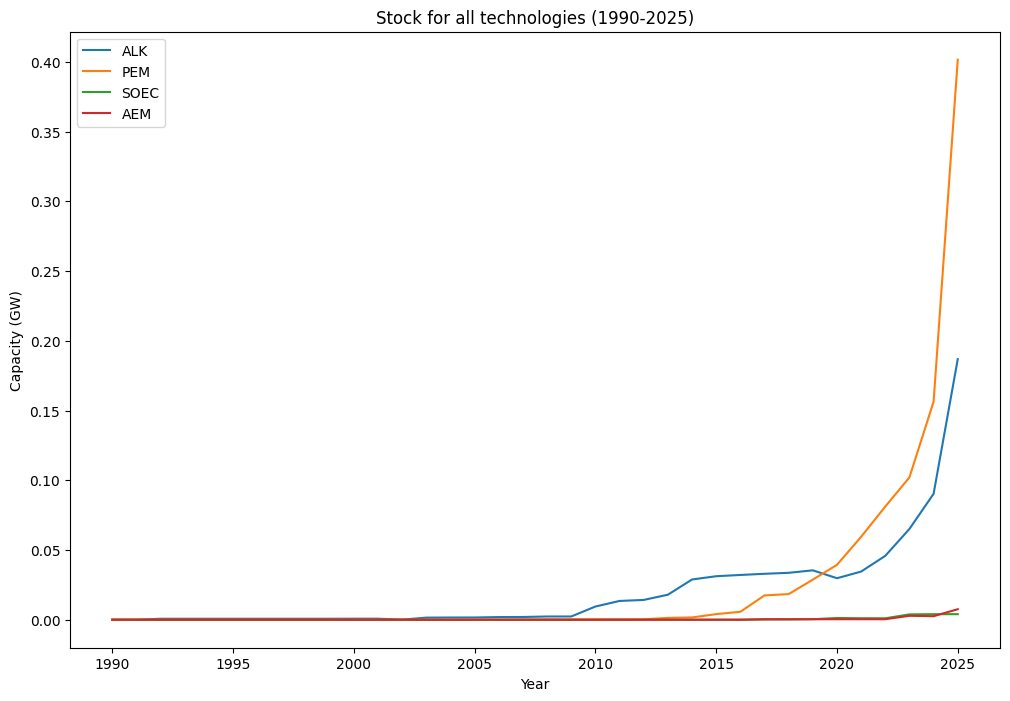

In [68]:
# Plot stock for all technologies

plt.figure(figsize=(12, 8))
plt.plot(t, s_alk/1000, label="ALK")
plt.plot(t, s_pem/1000, label="PEM")
plt.plot(t, s_soec/1000, label="SOEC")
plt.plot(t, s_aem/1000, label="AEM")
plt.title("Stock for all technologies (1990-2025)")
plt.xlabel("Year")
plt.ylabel("Capacity (GW)")
plt.legend()
plt.show()

Export data

In [69]:
# Export the historic electrolyser data to a csv file
output_path = Path.cwd().parent / "data" / "processed" / "electrolysers" / "historic_electrolyser_capacity.csv"
historic_data_pivot.to_csv(output_path, index=False)